# Résolution de l'Equation de la Chaleur

## Résolution pour une solution $u$ triviale

Dans cette partie, on s'intéresse à la résolution de l'équation de la chaleur, c'est à dire à la discrétisation du problème suivant : 

$$
\left\{
    \begin{array}{ll}
        \dfrac{\partial u}{\partial t} = \Delta u &{sur }\quad \Omega = [0,1]\times[0,1]\\
        u = 0 &\mbox{sur } \quad \partial \Omega
    \end{array}
\right.
$$

Nous remarquons que nous utilisons des conditions de bord de type Dirichlet. Pour approximer la solution, nous allons utiliser une méthode de discrétisation par différence finie de type implicite. Nous obtenons le calcul suivant :

$$
\dfrac{U^{n+1} - U^n}{\delta t} = AU^{n+1}
$$

où $U$ représente le vecteur solution et $A$ la matrice de discrétisation du Laplacien. Le réel $\delta t$ représente le pas de temps. Le vecteur $u$ est dit trivial dans le titre de cette partie car nous l'initialiserons à un vecteur de 1 tout en prenant en compte les conditions de bord. Dans la partie suivante, nous appliquerons cette équation de diffusion à une fonction $u$ donnée.

Nous obtenons l'expression finale : 

$$
U^{n+1} = (I - \delta t A)^{-1}U^n
$$

La stratégie adoptée pour coder ce problème sera la suivante. Dans un premier temps, nous allons écrire la matrice de $(I -\delta t A)$ en s'inspirant de notre travail sur l'équation de Poisson. Dans un second temps, nous ajouterons la boucle temporelle et nous finirons par afficher le résultat final.

Pour commencer, nous allons importer les packages nécessaires.

In [29]:
import numpy as np                        #Package pour calculs scientifiques
import scipy.sparse as sparse             #Algèbre linéaire creuse
import matplotlib.pyplot as plt           #Permet la création de graphique  
import scipy.sparse.linalg as sci         #Contient plusieurs packages pour le calcul scientifique
from mpl_toolkits.mplot3d import Axes3D   #Utile pou le graphiques 3D
import time                               #Affichage du temps de calcul
from IPython.display import Image         #Affichage d'image dans le Jupyter

La fonction suivante retourne la matrice de $(I - \delta t A)$. Ce sera une matrice sparse de taille $(N+1)\times(N+1)$. Elle regroupera donc l'intégralité des points du maillage et nous permettra de résoudre le système linéaire en insérant les conditions de bords ($u = 0$) directement dans le second membre. La fonction suivante prendra en paramètre le nombre $N$ d'intervalles et la pas de temps $\delta t$.

In [2]:
def matrix_lap2(N,dt):
    """Retourne la matrice de (I -dtA) dans le domaine Omega = [0,1]x[0,1] 
    découpé en N intervalles en x et y. La matrice finale est une matrice scipy.sparse CSR matrix. 
    Cette matrice est de taille (N+1)*(N+1)"""

    h = 1./N
    h2 = h*h

    #On note les inconnues de 0 à Nx suivant x et 0 à Ny suivant y. La taille du problème est donc (Nx+1)*(Ny+1).
    #Ici le pas d'espace est le même entre x et y.
    #Cela correspond à x_i = i*h et y_j = j*h et la numérotation (i,j) --> k := (N+1)*j+i.

    taille = (1+N)*(1+N)

    diags = np.zeros((5,taille))                          #Création du tableau des diagonales

    #Diagonale principale
    diags[2,:] = 1.
    diags[2, N+2:taille - (N+2)] = 1 + ((4*dt)/h2)
    diags[2, np.arange(2*N+1, taille, N+1)] = 1.
    diags[2, np.arange(2*N+2, taille, N+1)] = 1.
              
    #Diagonale "-1"
    diags[1,N+1:taille-(N+1)] = -dt/h2
    diags[1, np.arange(2*N, taille, N+1)] = 0.
    diags[1, np.arange(2*N+1, taille, N+1)] = 0.
    
    #Diagonale "+1"
    diags[3, N+3:taille-(N+1)] = -dt/h2
    diags[3, np.arange(2*N+2, taille, N+1)] = 0.
    diags[3, np.arange(2*N+3, taille, N+1)] = 0.

    #Diagonale "-(N+1)"
    diags[0, 1 : taille - (2*N+3)] = -dt/h2
    diags[0, np.arange(N,taille,N+1)] = 0.
    diags[0, np.arange(N+1,taille,N+1)] = 0.

    #Diagonale "+(N+1)"
    diags[4, taille - N*N + 2 : taille - 1] = -dt/h2
    diags[4, np.arange(taille - N*N + 1 + N ,taille,N+1)] = 0.
    diags[4, np.arange(taille - N*N + 2 + N ,taille,N+1)] = 0.

    #Construction de la matrice creuse
    A = sparse.spdiags(diags,[-(N+1),-1,0,1,(N+1)],taille,taille, format = "csc")

    return A


Regardons ce qu'affiche la matrice $A$ pour $N = 2$ et un pas de temps $\delta t = 0.1$

In [3]:
A = matrix_lap2(2,0.1)
print(A.todense())

[[ 1.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   1.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   1.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   1.   0.   0.   0.   0.   0. ]
 [ 0.  -0.4  0.  -0.4  2.6 -0.4  0.  -0.4  0. ]
 [ 0.   0.   0.   0.   0.   1.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   1.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   1.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   1. ]]


Nous pouvons aussi, comme en début de rapport de voir un aperçu graphique de la matrice pour une valeur de $N = 7$

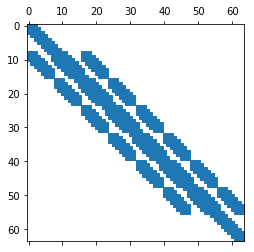

In [4]:
plt.spy(matrix_lap2(7,0.1))

On remarque que la matrice obtenue correspond, visuellement, à celle que l'on doit obtenir. Finalement, on rédige l'algorithme pour résoudre le système linéaire. Nous avons décidé de créer un tableau des temps en 2 dimensions, dans lequel on stockera la solution à chaque temps $t$. Cela permettra à l'utilisateur de choisir quel temps il voudra afficher dans un intervalle $[0,T]$. Dans le cadre de ce rapport, nous afficherons seulement pour $t = 0$ et $t = T$. Le fait de stocker la solution, à chaque temps, dans un tableau peut-être très coûteuse. Nous verrons par la suite qu'il est également possible de stocker chaque solution dans un fichier, ce qui rend l'opération moins lourde pour l'ordinateur. On obtient la fonction suivante.

In [5]:
def chaleur_triv(N,dt,t):

    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)

    taille1 = (N+1)*(N+1)

    #Initialisation du tableau en 2 dimensions, (t+1) en première composante pour le nombre de d'intervalle de temps
    #et (taille1) en seconde composante pour stocker le tableau de solution
    
    T = np.zeros((t+1,taille1))     
    
    #Initialisation de la solution finale. On met des 0 sur les bords pour valider les conditions initiales 
    #et on initialise le reste à 1. 
    
    T[0,N+2:taille1 - N-2] = 1.
    T[0,np.arange(2*N+1, taille1, N+1)] = 0
    T[0,np.arange(2*N+2, taille1, N+1)] = 0

    #On fait la boucle temporelle en stockant la solution à chaque temps. On utilise un solveur avec une méthode
    #pour matrice sparse.
    
    for i in range (t):                 
         T[i+1,:] = sci.spsolve(matrix_lap2(N,dt),T[i,:])

    return T 

Finalement on va procéder à l'affichage de la solution discrétisée. On se propose ici d'afficher la solution au temps $t = 1 $ et au temps $t = T$. Cependant l'utilisateur peut changer la valeur du paramètre pour l'afficher au temps $t \in [0,T]$. On va utiliser ici une valeur de $N = 200$, $\delta t= 0.01$ et $T = 10$.

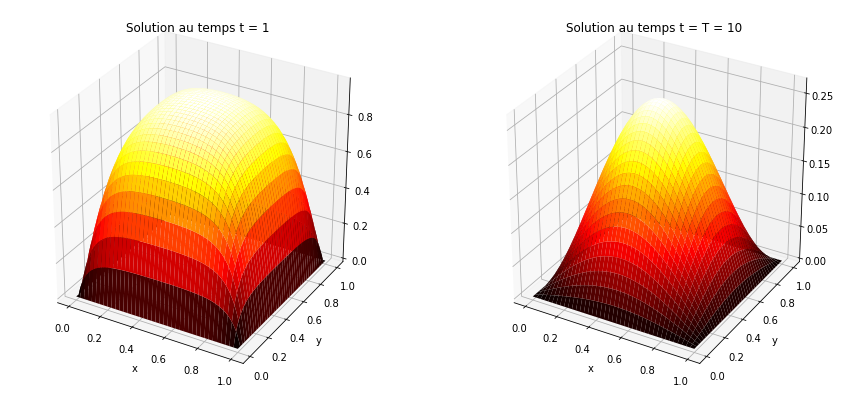

In [23]:
N = 200
t = 10

#Création du Tableau de temps
T = chaleur_triv(N,0.01,t)

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)

#Création de l'environnement de la figure
fig = plt.figure(figsize = [15,7])

#Premier subplot pour la solution au temps t = 1
ax = fig.add_subplot(1,2,1, projection = '3d')
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,T[1,:].reshape(N+1,N+1) ,cmap='hot')
plt.title("Solution au temps t = 1")
plt.xlabel("x")
plt.ylabel("y")

#Second subplot pour la solution au temps t = 10
ax = fig.add_subplot(1,2,2, projection = '3d')
ax.plot_surface(X,Y,T[t,:].reshape(N+1,N+1) ,cmap='hot')
plt.title("Solution au temps t = T = 10")
plt.xlabel("x")
plt.ylabel("y")

plt.show()

Nous allons maintenant écrire un algorithme permettant de stocker la solution à chaque temps dans un fichier. 

In [51]:
def chaleur_triv_files(N,dt,t):

    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)

    taille1 = (N+1)*(N+1)

    #Initialisation du tableau de la solution
    
    T = np.zeros(taille1)     
    
    #Initialisation de la solution finale. On met des 0 sur les bords pour valider les conditions initiales 
    #et on initialise le reste à 1. 
    
    T[N+2:taille1 - N-2] = 1.
    T[np.arange(2*N+1, taille1, N+1)] = 0
    T[np.arange(2*N+2, taille1, N+1)] = 0

    #On fait la boucle temporelle en stockant la solution à chaque temps dans un fichier txt. 
    #On utilise un solveur avec une méthode pour matrice sparse.
    
    for i in range (t+1):
        np.savetxt('Temps {}.txt'.format(i), T.reshape(N+1,N+1))
        T = sci.spsolve(matrix_lap2(N,dt),T)

In [52]:
chaleur_triv_files(200,0.01,10)

Dans notre répertoire, 11 fichiers textes sont apparus, chacun contenant la solution du temps $t$.

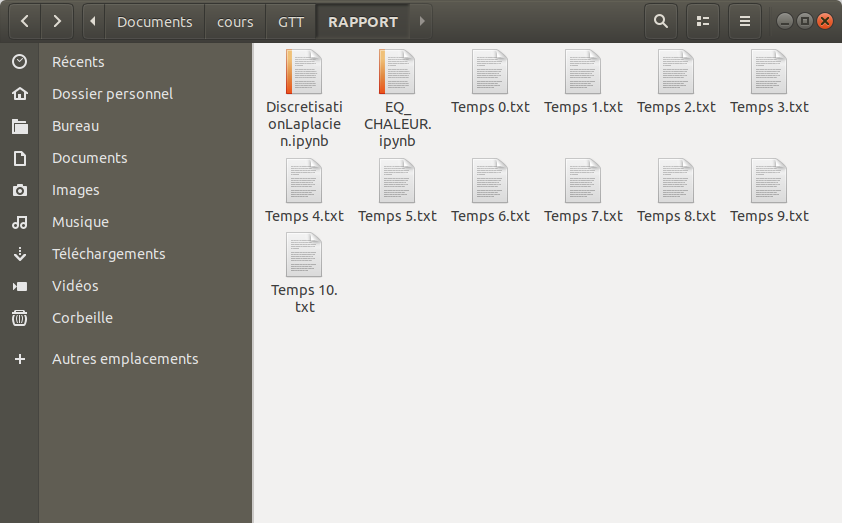

In [54]:
Image("/home/matthieu/Documents/cours/GTT/RAPPORT/Solutionstemps.png", width = 700)

Nous allons afficher la solution au temps $T = 1$ et $T = 10$ afin de voir si l'on retrouve les mêmes solutions que pour le tableau de temps précédent.

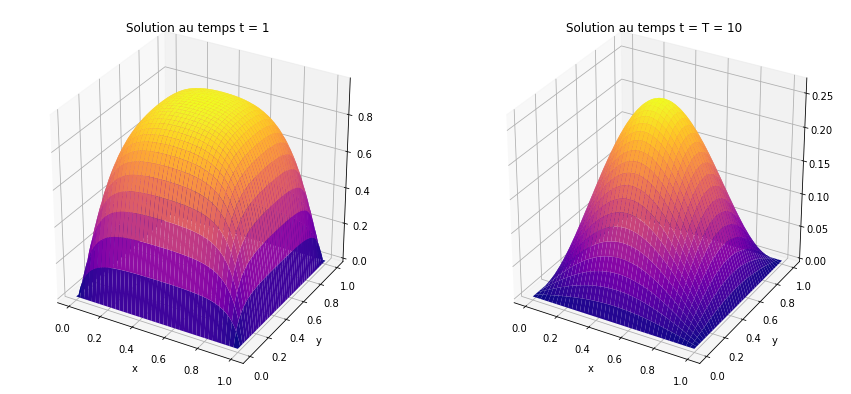

In [55]:
solt1 = np.loadtxt("Temps 1.txt")                #On charge le fichier pour le temps 1
solt10 = np.loadtxt("Temps 10.txt")               #On charge le fichier pour le temps 10

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)

fig = plt.figure(figsize = [15,7])

#Premier subplot pour la solution au temps t = 1

ax = fig.add_subplot(1,2,1, projection = '3d')
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,solt1,cmap='plasma')         #On change la couleur de l'affichage pour le plaisir des yeux
plt.title("Solution au temps t = 1")
plt.xlabel("x")
plt.ylabel("y")

#Second subplot pour la solution au temps t = 10

ax = fig.add_subplot(1,2,2, projection = '3d')
ax.plot_surface(X,Y,solt10 ,cmap='plasma')
plt.title("Solution au temps t = T = 10")
plt.xlabel("x")
plt.ylabel("y")

plt.show()

On remarque finalement que les courbes obtenues sont identiques. Nous avons donc vu deux méthodes pour stocker les données d'une solution. Il faudra, pour des raisons de coûts de calcul ainsi qu'une éventuelle volonté de les sauvegarder sur le disque dur, privilégier le stockage des tableaux dans des fichiers textes. Cependant, dans la suite du rapport, nous utiliserons la méthode de stockage directement dans un tableaux numpy.

## Résolution de l'équation de la chaleur pour une solution $u$ donnée

Dans cette partie, on s'intéresse à la résolution de l'équation de la chaleur avec une fonction $u$ donnée, c'est à dire à la discrétisation du problème suivant: 

$$
\left\{
    \begin{array}{ll}
        \dfrac{\partial u}{\partial t} = \Delta u &{sur }\quad \Omega = [0,1]\times[0,1]\\
        u = 0 &\mbox{sur } \quad \partial u  
    \end{array}
\right.
$$

où $$ u(x_1,x_2) = x_1x_2(x_1-1)^3(x_2-1)^3$$

On remarque que la fonction donnée répond bien au problème posé, pariculièrement au niveau des conditions de bord. En effet, pour $x1 = 0$ ou $x2 = 0$, la fonction est nulle. Nous allons utiliser une méthode de discrétisation implicite comme précédemment. Nous allons donc réutiliser les mêmes fonctions. Le seul changement résidera dans le code de la fonction $u$. On commence par écrire la fonction dont nous avons besoin.

In [62]:
def u(x1,x2):
    return x1*x2*((x1-1.)**3)*((x2-1))**3

Et on écrit le code qui sera très inspiré de ce qui a été fait avant : 

In [63]:
def chaleur_ex(N,dt,t):
    
    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)
    
    taille1 = (N+1)*(N+1)

    V = np.zeros((t+1,taille1))                             #Allocation mémoire sol exacte et tableau de temps
    
    for i in np.arange(N+1):                                #Calcul de la solution en tout point du maillage
        for j in np.arange(N+1):
            k = i + j*(N+1)
            V[0,k] = u(x[i],y[j])

    for i in range (t):                                    #Boucle temporelle utilisant le même solveur qu'avant
        V[i+1,:] = sci.spsolve(matrix_lap2(N,dt),V[i,:])

    return V

On affiche finalement le résultat pour des valeurs $N = 200$, $\delta t = 0.01$. 

Selon les informations données en cours, nous devrions obtenir les résultats suivants : 

$$\begin{array}{ll}
t &= 1 &\Longrightarrow \max(u) = 0.007773\\  
t &= 2 &\Longrightarrow \max(u) = 0.005619 
\end{array}
$$
Regardons si nous retrouvons ces résultats.

Pour t = 1, le maximum atteint est 0.007773079850730673
Pour t = 2, le maximum atteint est 0.0056197497221826655


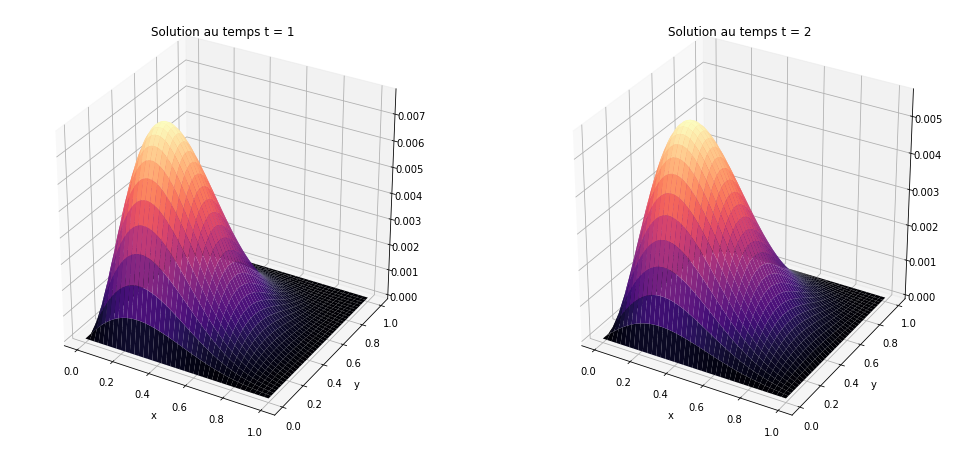

In [66]:
N = 200

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)

#Création de la solution avec un temps à 2 

V = chaleur_ex(N,0.01,2)

#Affichage des maximums

print('Pour t = 1, le maximum atteint est '+str(np.max(V[1,:])))

print('Pour t = 2, le maximum atteint est '+str(np.max(V[2,:])))

#Création de l'environnement pour la figure

fig = plt.figure(figsize = [17,8])

#Premier subplot pour la solution au temps = 1
ax = fig.add_subplot(1,2,1, projection = '3d')
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,V[1,:].reshape(N+1,N+1) ,cmap='magma')   #Les maths, c'est amusant, donc on rechange les couleurs
plt.title("Solution au temps t = 1")
plt.xlabel("x")
plt.ylabel("y")

#Second subplot pour la solution au temps = 2
ax = fig.add_subplot(1,2,2, projection = '3d')
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,V[2,:].reshape(N+1,N+1) ,cmap='magma')
plt.title("Solution au temps t = 2")
plt.xlabel("x")
plt.ylabel("y")

plt.show()

Nous pouvons donc conclure que notre approximation est bonne.

## La fonction distance sur un domaine carré

Dans cette partie, nous allons écrire le code pour la rédaction de la fonction distance. 

In [67]:
def chaleurdist(N,dt,t):
    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)

    taille1 = (N+1)*(N+1)
    T = np.ones((t+1,taille1))          #Initialisation de la solution finale
    T[0,N+2:taille1 - N-2] = 0
    T[0,np.arange(2*N+1, taille1, N+1)] = 1.
    T[0,np.arange(2*N+2, taille1, N+1)] = 1.


    for i in range (t):
        T[i+1,:] = sci.spsolve(matrix_lap2(N,dt),T[i,:])

    return T

In [68]:
def dist(N,dt):

    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)

    T = chaleurdist(N,dt,1)

    dist  = - np.log(T[1,:])*np.sqrt(dt)
    
    return dist

On affiche la solution. Selon les informations données en cours, nous devrions voir s'afficher une pyramide avec comme valeur maximale $max(dist) = 0.4935556$, pour $N = 1000$ et $\delta t = 0.00001$.

In [ ]:
N = 1000

DIST = dist(N,0.00001)

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)

print('La valeur maximale de la fonction distance est '+str(np.max(DIST)))

fig = plt.figure(figsize = [8,8])
    
ax = fig.add_subplot(111, projection = '3d')
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,DIST.reshape(N+1,N+1) ,cmap='hot')
plt.title("Graphique de la fonction distance")
plt.xlabel("x")
plt.ylabel("y")

plt.show()